This notebook evaluates the StarNet model to the prior parameters

- $\mu$, the Poisson mean on the number of stars 
- $\alpha$, the power-law slope on the flux distribution


To produce the fits used here, in the `./experiments_m2/` folder run 
```
# sensitivity to Poisson mean parameter on number of stars 
./get_prior_alpha_sensitivity.sh

# sensitivity to flux power-law slope
get_prior_alpha_sensitivity.sh
```

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch

import deblending_runjingdev.sdss_dataset_lib as sdss_dataset_lib
import deblending_runjingdev.image_utils  as image_utils

import deblending_runjingdev.starnet_lib as starnet_lib
import deblending_runjingdev.image_statistics_lib as image_statistics_lib

from deblending_runjingdev.which_device import device

In [2]:
np.random.seed(453)
_ = torch.manual_seed(786)

# Load m2 data

In [3]:
sdss_image, sdss_background, hubble_locs, hubble_fluxes, sdss_data, wcs = \
    sdss_dataset_lib.load_m2_data()

loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



 returning image at x0 = 630, x1 = 310


In [4]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

In [5]:
true_mags = sdss_dataset_lib.convert_nmgy_to_mag(hubble_fluxes / nelec_per_nmgy)

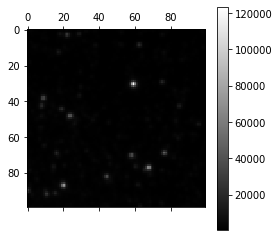

In [6]:
# the subimage of M2
plt.matshow(sdss_image[0].cpu(), cmap = plt.cm.gray)
plt.colorbar()

# Define StarNet

In [7]:
star_encoder = starnet_lib.StarEncoder(slen = 100, 
                                       ptile_slen = 8,
                                       step = 2,
                                       edge_padding = 3, 
                                       n_bands = 2,
                                       max_detections = 2)

# Functions for plotting and computing statistics

In [8]:
axis_label_size = 16
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

# colors for plotting (copied from colorbrewer)
color_vec = ['#1b9e77','#d95f02','#7570b3']

In [9]:
mag_vec = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

In [10]:
def plot_sensitivity(encoder_files, legend_labels): 
    
    fig, axarr = plt.subplots(1, 2, figsize=(13, 5))

    for i in range(len(encoder_files)): 
        
        ###################
        # load encoder
        ###################
        print('loading encoder from : ', encoder_files[i])
        
        star_encoder.load_state_dict(torch.load(encoder_files[i],
                               map_location=lambda storage, loc: storage))
        
        star_encoder.eval(); 
        star_encoder.to(device); 
        
        ###################
        # get map catalog
        ###################
        map_locs, map_fluxes, map_n_stars = \
            star_encoder.sample_star_encoder(sdss_image.unsqueeze(0), 
                                             return_map_n_stars = True,
                                             return_map_star_params = True, 
                                             tile_n_stars = None)[0:3]
        
        ###################
        # get statistics as function of magnitude
        ###################
        tpr_vec = \
            image_statistics_lib.get_tpr_vec(map_locs.squeeze(), 
                                                hubble_locs.squeeze(), 
                                                star_encoder.slen, 
                                                map_fluxes.squeeze(0)[:, 0], 
                                                hubble_fluxes.squeeze(0)[:, 0],
                                                nelec_per_nmgy,
                                                mag_vec = mag_vec)[0]

        ppv_vec = \
            image_statistics_lib.get_ppv_vec(map_locs.squeeze(), 
                                                hubble_locs.squeeze(), 
                                                star_encoder.slen, 
                                                map_fluxes.squeeze(0)[:, 0], 
                                                hubble_fluxes.squeeze(0)[:, 0], 
                                                nelec_per_nmgy, 
                                                mag_vec = mag_vec)[0]
        ###################
        # plot
        ###################
        x_tmp = np.arange(len(mag_vec))
        axarr[0].plot(x_tmp[:-1], tpr_vec, '-^', 
                      markersize = markersize,
                      linewidth = linewidth, 
                      color = color_vec[i])    

        axarr[1].plot(x_tmp[:-1], ppv_vec, '-^', 
                      markersize = markersize,
                      linewidth = linewidth, 
                      color = color_vec[i],
                      label = legend_labels[i])

    ###################
    # stuff with axis labels
    ###################
    labels_raw = np.round(mag_vec, 1)
    labels = ['[' + str(labels_raw[i]) + ', ' + str(labels_raw[i+1]) + ')' for i in range(len(labels_raw) - 1)]

    labels[0] = '< ' + str(labels_raw[1])
    labels[-1] = '> ' + str(labels_raw[-2])

    for i in range(2): 
        axarr[i].set_xticks(x_tmp[:-1])
        axarr[i].set_xticklabels(labels, rotation=45, ha = 'right', 
                                 fontsize = axis_label_size * 0.6)

    axarr[0].set_xlabel('Hubble magnitude', fontsize = axis_label_size)
    axarr[1].set_xlabel('Estimated magnitude', fontsize = axis_label_size)

    axarr[0].set_ylabel('True postive rate', fontsize = axis_label_size)
    axarr[1].set_ylabel('Positive predictive value', fontsize = axis_label_size)
    axarr[1].legend(prop={'size': legendsize})

    fig.tight_layout()
    
    return fig

In [11]:
def print_summary_statistics(encoder_files, param_vec): 
    
    tpr_vec = torch.zeros(len(param_vec))
    ppv_vec = torch.zeros(len(param_vec))
    
    for i in range(len(param_vec)): 
        
        # load encoder
        star_encoder.load_state_dict(torch.load(encoder_files[i],
                               map_location=lambda storage, loc: storage))
        star_encoder.eval(); 
        
        # get estimates
        map_locs, map_fluxes, map_n_stars = \
            star_encoder.sample_star_encoder(sdss_image.unsqueeze(0), 
                                             return_map_n_stars = True,
                                             return_map_star_params = True, 
                                             tile_n_stars = None)[0:3]
        
        # compue statistics
        tpr, ppv, _, _ = \
            image_statistics_lib.get_summary_stats(map_locs.squeeze(), 
                                                   hubble_locs.squeeze(), 
                                                   star_encoder.slen, 
                                                   map_fluxes.squeeze(0)[:, 0], 
                                                   hubble_fluxes.squeeze(0)[:, 0], 
                                                  nelec_per_nmgy)

        tpr_vec[i] = tpr
        ppv_vec[i] = ppv
    
    print(pd.DataFrame({'param': param_vec, 
                        'TPR': tpr_vec, 
                        'PPV': ppv_vec}))

# Sensitivity to Poisson parameter

In [12]:
fits_dir = '../fits/prior_sensitivity/'

In [13]:
encoder_files = [fits_dir + 'starnet_mu1000-encoder-iter2', # mu = 1000
                 fits_dir + '../starnet-encoder-iter2', # the default, mu = 1500
                 fits_dir + 'starnet_mu2000-encoder-iter2' # mu = 2000
                ]

mu_vec = [0.1, 0.15, 0.2]
legend_labels = ['mu = {:.02f}'.format(mu) for mu in mu_vec]

loading encoder from :  ../fits/prior_sensitivity/starnet_mu1000-encoder-iter2


/home/runingli/anaconda3/envs/deblending_pytorch_testing/lib/python3.8/site-packages/deblending_runjingdev/image_utils.py:179: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  indx[indx == 1] = torch.nonzero(tile_is_on_bool)[:, 1]


loading encoder from :  ../fits/prior_sensitivity/../starnet-encoder-iter2
loading encoder from :  ../fits/prior_sensitivity/starnet_mu2000-encoder-iter2
   param       TPR       PPV
0   0.10  0.461869  0.657617
1   0.15  0.505908  0.600751
2   0.20  0.512352  0.485743


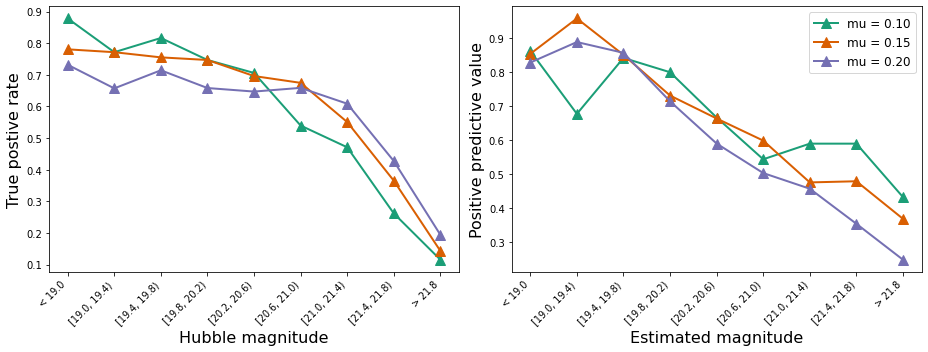

In [14]:
fig = plot_sensitivity(encoder_files, legend_labels)
print_summary_statistics(encoder_files, mu_vec)

fig.savefig('../../figures/prior_sensitivity/prior_mu_sensitivty.png')

# Sensitivity to Pareto alpha parameter

In [15]:
encoder_files = ['../fits/prior_sensitivity/starnet_alpha0.25-encoder-iter2', 
                '../fits/starnet-encoder-iter2', 
                '../fits/prior_sensitivity/starnet_alpha0.75-encoder-iter2']

alpha_vec = [0.25, 0.5, 0.75]

legend_labels = ['alpha = {:.02f}'.format(alpha) for alpha in alpha_vec]

loading encoder from :  ../fits/prior_sensitivity/starnet_alpha0.25-encoder-iter2
loading encoder from :  ../fits/starnet-encoder-iter2
loading encoder from :  ../fits/prior_sensitivity/starnet_alpha0.75-encoder-iter2
   param       TPR       PPV
0   0.25  0.458647  0.604196
1   0.50  0.505908  0.600751
2   0.75  0.517723  0.535556


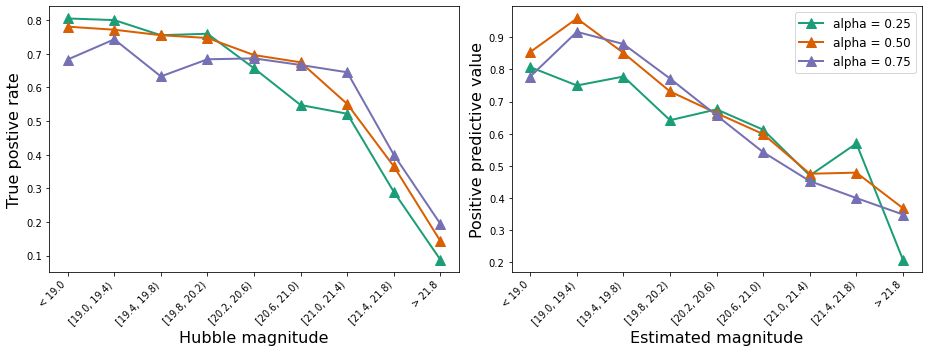

In [16]:
fig = plot_sensitivity(encoder_files, legend_labels)
print_summary_statistics(encoder_files, alpha_vec)

fig.savefig('../../figures/prior_sensitivity/prior_alpha_sensitivity.png')

# Plot CDF of magnitudes

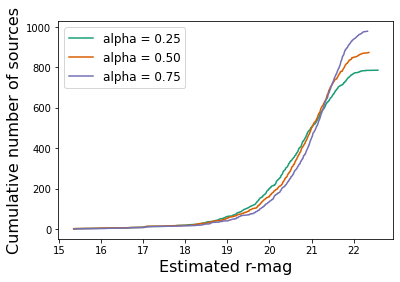

In [17]:
for i in range(len(alpha_vec)): 
    star_encoder.load_state_dict(torch.load(encoder_files[i],
                           map_location=lambda storage, loc: storage))
    star_encoder.eval(); 
    star_encoder.to(device); 

    map_locs, map_fluxes, map_n_stars = \
        star_encoder.sample_star_encoder(sdss_image.unsqueeze(0), 
                                         return_map_n_stars = True,
                                         return_map_star_params = True, 
                                         tile_n_stars = None)[0:3]
    
    mags = sdss_dataset_lib.convert_nmgy_to_mag(map_fluxes[0, :, 0] / nelec_per_nmgy).detach()
    mags = mags.sort()[0]
    plt.plot(mags.cpu().numpy(), 
             np.arange(len(mags)),
             label = legend_labels[i],
             color = color_vec[i])
    
plt.xlabel('Estimated r-mag', fontsize = axis_label_size)
plt.ylabel('Cumulative number of sources', fontsize = axis_label_size)
plt.legend(prop={'size': legendsize})

plt.savefig('../../figures/prior_sensitivity/sensitivity_cdf_fluxes.png')

# Plot the prior on magnitude

In [19]:
import deblending_runjingdev.simulated_datasets_lib as simulated_datasets_lib

In [22]:
x = simulated_datasets_lib._draw_pareto(1000., 0.25, (1000000, ))
mags = sdss_dataset_lib.convert_nmgy_to_mag(x / nelec_per_nmgy).cpu()

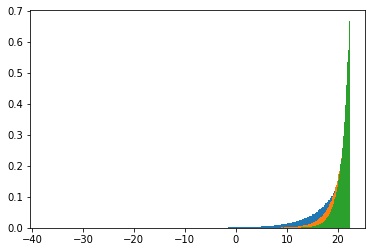

In [25]:
# alpha = 0.25
x = simulated_datasets_lib._draw_pareto(1000., 0.25, (1000000, ))
mags = sdss_dataset_lib.convert_nmgy_to_mag(x / nelec_per_nmgy).cpu().numpy()
counts1, bins1 = plt.hist(mags, bins = 200, density=True)[0:2]

# alpha = 0.5 
x = simulated_datasets_lib._draw_pareto(1000., 0.5, (1000000, ))
mags = sdss_dataset_lib.convert_nmgy_to_mag(x / nelec_per_nmgy).cpu().numpy()
counts2, bins2 = plt.hist(mags, bins = 200, density=True)[0:2]

# alpha = 0.75
x = simulated_datasets_lib._draw_pareto(1000., 0.75, (1000000, ))
mags = sdss_dataset_lib.convert_nmgy_to_mag(x / nelec_per_nmgy).cpu().numpy()
counts3, bins3 = plt.hist(mags, bins = 200, density=True)[0:2]

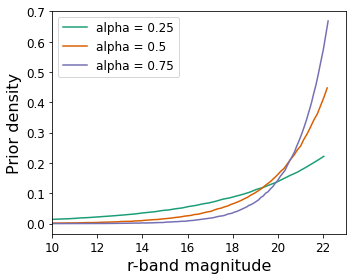

In [28]:
fig, axarr = plt.subplots(1, 1, figsize=(5, 4))

axarr.plot(bins1[0:len(counts1)], counts1, label = 'alpha = 0.25', color = color_vec[0])
axarr.plot(bins2[0:len(counts2)], counts2, label = 'alpha = 0.5', color = color_vec[1])
axarr.plot(bins3[0:len(counts3)], counts3, label = 'alpha = 0.75', color = color_vec[2])

axarr.set_xlim(10, 23)
axarr.legend()

axarr.legend(prop={'size': legendsize})
axarr.tick_params(labelsize = ticksize)
axarr.set_ylabel('Prior density', fontsize = axis_label_size)
axarr.set_xlabel('r-band magnitude', fontsize = axis_label_size)

fig.tight_layout()

fig.savefig('../../figures/prior_sensitivity/prior_fluxes.png')